In [23]:
import pandas as pd
from rdkit import Chem
from janitor.chemistry import morgan_fingerprint
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, matthews_corrcoef, roc_curve, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set(rc={'figure.figsize': (7, 7)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

In [3]:
df = pd.read_csv("../data/BBBP.csv")

In [4]:
df.head()

,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [5]:
df['mol'] = [Chem.MolFromSmiles(x) for x in tqdm(df.smiles)]

RDKit ERROR: [16:24:40] Explicit valence for atom # 1 N, 4, is greater than permitted
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [16:24:40] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit ERROR: [16:24:40] Explicit valence for atom # 6 N, 4, is greater than permitted
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:

RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:40] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [16:24:40] WARNING: not r

In [6]:
pd.isna(df.mol).value_counts()

False    2039
True       11
Name: mol, dtype: int64

In [7]:
df.shape

(2050, 5)

In [8]:
df.dropna(inplace=True)

In [9]:
df.shape

(2039, 5)

In [10]:
fp_df = morgan_fingerprint(df,mols_column_name="mol")

In [11]:
combo_df = df[["p_np"]].join(fp_df)

In [12]:
train,test = train_test_split(combo_df)

In [13]:
xgb = XGBClassifier()

In [14]:
fp_cols = list(train.columns[1:])

In [15]:
xgb.fit(train[fp_cols],train.p_np)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [16]:
pred = xgb.predict(test[fp_cols])
prob = xgb.predict_proba(test[fp_cols])

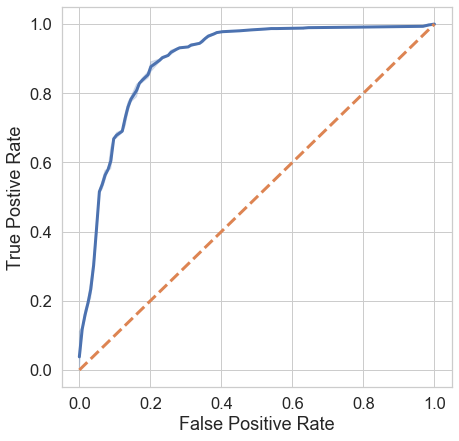

In [17]:
fpr, tpr, _ = roc_curve(test.p_np, prob[:,1])
ax = sns.lineplot(fpr,tpr,lw=3)
ax.set(xlabel="False Positive Rate",ylabel="True Postive Rate")
_ = ax.plot([0,1],[0,1],ls="--",lw=3)

In [18]:
roc_auc_score(test.p_np,prob[:,1])

0.8970102791241852

In [19]:
matthews_corrcoef(test.p_np,pred)

0.6726258311484374

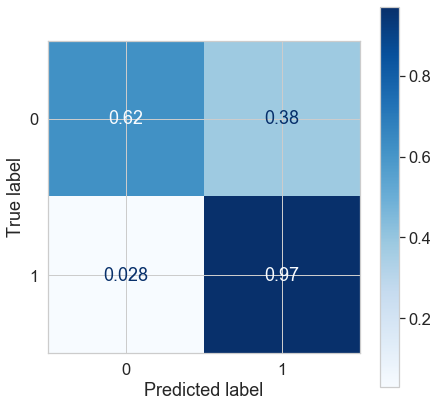

In [27]:
ax = plot_confusion_matrix(xgb, test[fp_cols], test.p_np, cmap=plt.cm.Blues, normalize='true')